In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras

In [4]:
#from keras.utils import normalize
from keras.utils.np_utils import normalize
from keras.metrics import MeanIoU

In [5]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
#n_classes=4

In [6]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("sandstone_data/128_patches/Images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        img = cv2.imread(img_path, 1)       
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [7]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("sandstone_data/128_patches/Masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        mask = cv2.imread(mask_path, 0)       
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [8]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0, 1, 2, 3], dtype=int64)

In [9]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [10]:
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3]


In [13]:
from keras.utils.np_utils import to_categorical

n_classes=4

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [15]:
#Reused parameters in all models

n_classes=4
activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [16]:
#VGG-16
BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

In [17]:
#preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

In [18]:
#define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

In [19]:
#compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics=metrics)

In [15]:
print(model3.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [44]:
history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test3, y_test_cat))

Epoch 1/50
90/90 [==============================] - 128s 1s/step - loss: 0.7872 - iou_score: 0.8425 - f1-score: 0.9058 - val_loss: 0.8969 - val_iou_score: 0.6305 - val_f1-score: 0.7414
Epoch 2/50
90/90 [==============================] - 126s 1s/step - loss: 0.7902 - iou_score: 0.8299 - f1-score: 0.8957 - val_loss: 0.9067 - val_iou_score: 0.6295 - val_f1-score: 0.7405
Epoch 3/50
90/90 [==============================] - 126s 1s/step - loss: 0.7872 - iou_score: 0.8410 - f1-score: 0.9047 - val_loss: 0.8881 - val_iou_score: 0.6136 - val_f1-score: 0.7270
Epoch 4/50
90/90 [==============================] - 126s 1s/step - loss: 0.7871 - iou_score: 0.8405 - f1-score: 0.9055 - val_loss: 0.9074 - val_iou_score: 0.5981 - val_f1-score: 0.7121
Epoch 5/50
90/90 [==============================] - 127s 1s/step - loss: 0.7986 - iou_score: 0.7980 - f1-score: 0.8741 - val_loss: 0.9036 - val_iou_score: 0.6028 - val_f1-score: 0.7186
Epoch 6/50
90/90 [==============================] - 127s 1s/step - loss: 0.

In [18]:
model3.save('vgg16_backbone_50epochs_sandstone.hdf5')

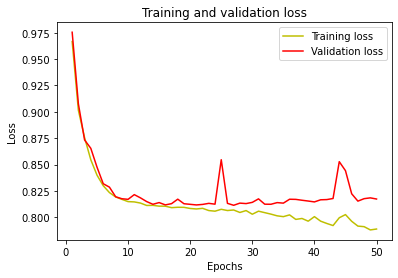

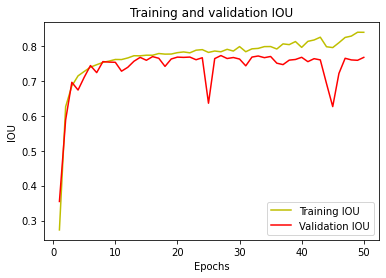

In [17]:
#Plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [20]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
model3 = load_model('vgg16_backbone_50epochs_sandstone.hdf5', compile=False)

In [21]:
#IOU
y_pred3=model3.predict(X_test3)
y_pred3_argmax=np.argmax(y_pred3, axis=3)

In [22]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred3_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7622597


In [23]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

[[3.004140e+05 6.135000e+03 3.844700e+04 8.920000e+02]
 [1.560400e+04 1.527920e+05 3.963000e+04 8.620000e+02]
 [4.467500e+04 2.635000e+04 1.904997e+06 5.778000e+03]
 [2.284000e+03 1.188000e+03 1.083300e+04 7.055900e+04]]


In [24]:
print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

IoU for class1 is:  0.7354958
IoU for class2 is:  0.62991166
IoU for class3 is:  0.91997284
IoU for class4 is:  0.7636586


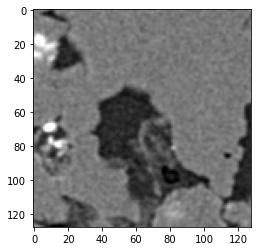

In [25]:
#Varify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')

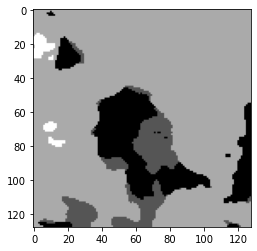

In [26]:
plt.imshow(train_masks[0], cmap='gray')

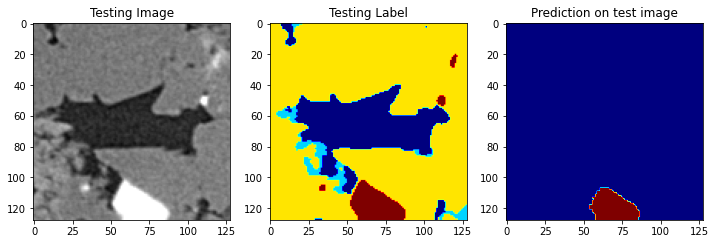

In [35]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test3))
test_img = X_test3[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input3(test_img_input)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()